In [1]:
%load_ext autoreload
%autoreload 3
from Probe import probe_shapelet
from utils.insert_shapelet import get_pdata, insert_random, overwrite_shaplet_random
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
from utils import *

In [2]:
device = 'cpu'

In [3]:
from tsai.models.FCN import FCN

model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt', map_location=device)
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = read_UCR_UEA('GunPoint', None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

In [4]:
xai_name = 'DeepLift'
with open(f'attributions/GunPoint/{xai_name}/exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

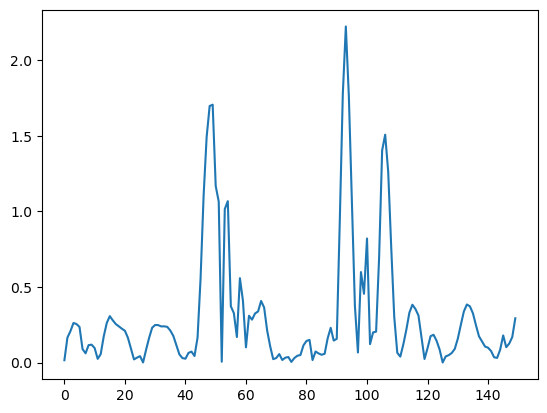

In [5]:
plt.plot(np.abs(attr_gp[2].flatten()))

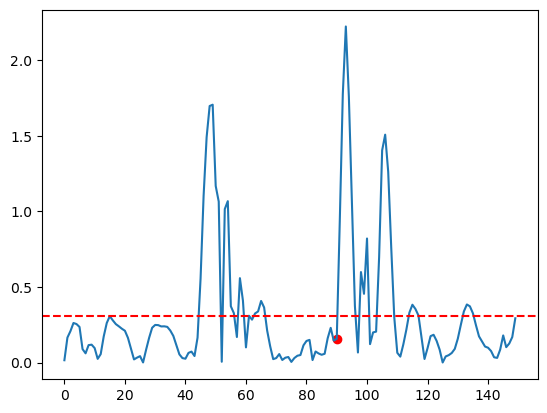

In [6]:
abs_attr = np.abs(attr_gp[2].flatten())
avg = np.mean(abs_attr)
plt.plot(np.abs(attr_gp[2].flatten()))
plt.axhline(avg, color='r', linestyle='--')
plt.scatter(90, abs_attr[90], color='r')

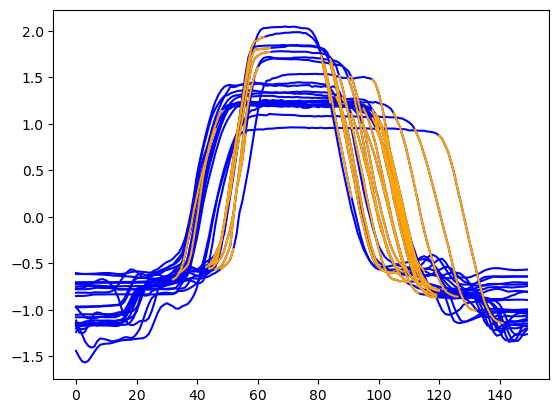

In [21]:
results = implets_class0#[0:5]
# plt.plot(np.abs(attr_gp[2].flatten()))
# for result in results:
#     _, sub_inst, sub_attr, max_score, best_start, best_end = result
#     plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
#     plt.axhline(avg, color='r', linestyle='--')
#     plt.scatter(90, abs_attr[90], color='r')
# plt.show()
inst_num_set = set()
for result in results:
    inst_num, sub_inst, sub_attr, max_score, best_start, best_end = result
    inst_num_set.add(inst_num)

for inst_num in inst_num_set:
    plt.plot(train_x[inst_num].flatten(), color='blue')

for result in results:
    inst_num, sub_inst, sub_attr, max_score, best_start, best_end = result
    # print(result)
    
    plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')
    
plt.show()

# plt.plot(attr_gp[2].flatten())
# for result in results:
#     i, sub_inst, sub_attr, max_score, best_start, best_end = result
#     plt.plot(np.arange(best_start, best_end + 1), attr_gp[i, best_start:best_end + 1], color='orange')
# plt.show()

In [15]:
implets_class0[3]

[3,
 array([1.5142188 , 1.3992524 , 1.2610293 , 1.1175746 , 0.95725203]),
 array([1.2650739 , 2.12043643, 2.20449734, 1.49192369, 0.76352441]),
 1.3919890880584718,
 87,
 91]

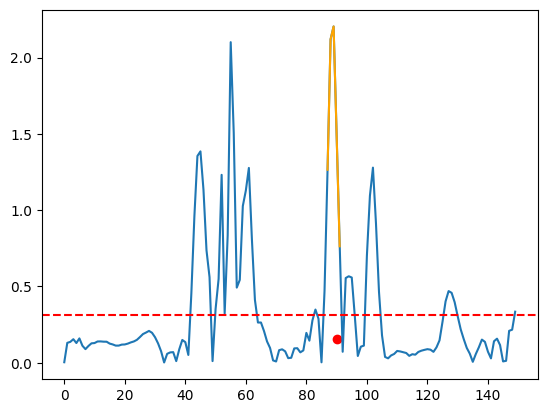

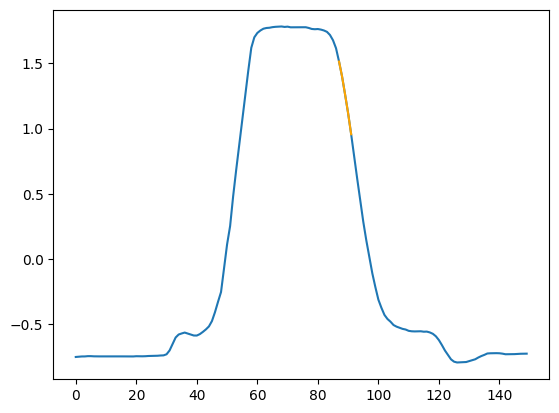

In [16]:
result = implets_class0[3]
i, sub_inst, sub_attr, max_score, best_start, best_end = result
plt.plot(np.abs(attr_gp[i].flatten()))
plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
plt.axhline(avg, color='r', linestyle='--')
plt.scatter(90, abs_attr[90], color='r')
plt.show()
plt.plot(train_x[i].flatten())
plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')
plt.show()

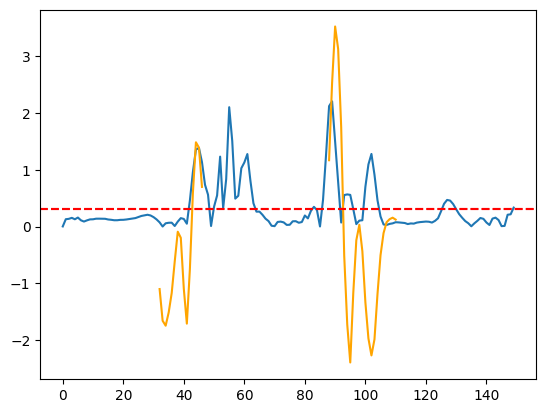

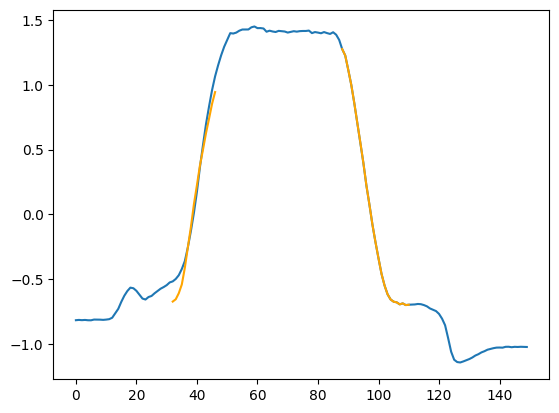

In [17]:
results = implets_class0[4:6]
plt.plot(np.abs(attr_gp[i].flatten()))
for result in results:
    i, sub_inst, sub_attr, max_score, best_start, best_end = result
    plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
    plt.axhline(avg, color='r', linestyle='--')
plt.show()
plt.plot(train_x[i].flatten())
for result in results:
    i, sub_inst, sub_attr, max_score, best_start, best_end = result
    plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')
plt.show()

In [18]:
# def plot_multiple_images_with_attribution(test_x, pred_y, n, shape, figsize=(12, 6), use_attribution=False,
#                                           attributions=None, normalize_attribution=True, title="", save_path=None,
#                                           test_y=None):


plot_multiple_images_with_attribution(
    np.array([imp[1] for imp in implets_class0]),
    np.array([0 for _ in implets_class0]),
    31,
    (8, 4),
    figsize=(24, 16),
    use_attribution=True,
    attributions=np.array([imp[2] for imp in implets_class0]),
    save_path='figure/implet_extract_gp.png'
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31,) + inhomogeneous part.

In [ ]:
from dtaidistance.clustering.kmeans import KMeans
from dtaidistance.dtw_barycenter import dba

implets_sub_class0 = [np.vstack((imp[1], imp[2])).T for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment, _ = kmeans.fit(implets_sub_class0, use_c=True)

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[:, 1])) for imp in implets_sub_class0])
norm = Normalize(vmin=-max_importance, vmax=max_importance)

ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])


# ymin -= (ymax - ymin) * 0.1
# ymax += (ymax - ymin) * 0.1

def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)


for i in range(k):
    members = assignment[i]
    for j in members:
        plot(implets_sub_class0[j][:, 0], implets_sub_class0[j][:, 1], axs[i], alpha=0.75)
    centroid = dba([implets_sub_class0[j] for j in members], None)
    # plot(centroid[:, 0], centroid[:, 1], axs[i], lw=3)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)

plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_depDTW.png')

In [ ]:
# 1d DTW clsutering

implets_sub_class0_1d = [imp[1] for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment_1d, _ = kmeans.fit(implets_sub_class0_1d, use_c=True)

In [ ]:
fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[1])) for imp in implets_sub_class0_1d])
norm = Normalize(vmin=-max_importance, vmax=max_importance)
ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])


def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)


for i in range(k):
    members = assignment_1d[i]
    centroid = dba([implets_sub_class0_1d[j] for j in members], None)
    print(centroid.shape)
    # axs[i].plot(centroid, lw=3, c='gray')
    for j in members:
        plot(implets_sub_class0_1d[j], implets_class0[j][2], axs[i], alpha=0.5)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)

plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_1dDTW.png')

## Testing masking shaplets

In [29]:
with open(f'attributions/GunPoint/{xai_name}/exp_test.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_test = attr['attributions']
implets_class0 = implet_extractor(test_x, test_y, attr_test, target_class=0)
implets_class1 = implet_extractor(test_y, test_y, attr_test, target_class=1)
implets = implets_class0 + implets_class1

In [30]:
implet = implets_class0[0]
sample_id, implet_vals, implet_attr, score, start_loc, end_loc = implet
sample = test_x[sample_id].flatten()

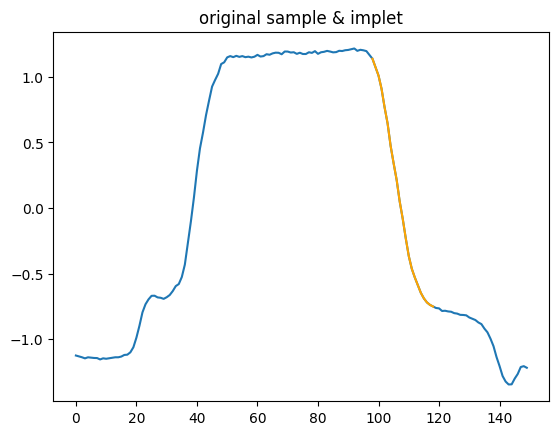

In [31]:
plt.plot(sample)
plt.plot(np.arange(start_loc, end_loc + 1), implet_vals, color='orange')
plt.title('original sample & implet')
plt.show()

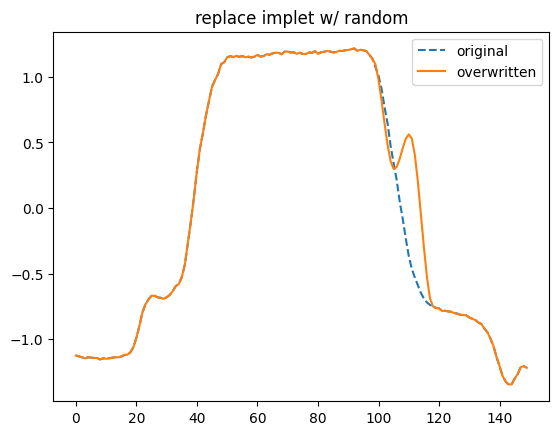

In [32]:
sample_overwritten = overwrite_shaplet_random(sample, start_loc, len(implet_vals))
plt.plot(sample, ls='--', label='original')
plt.plot(sample_overwritten, label='overwritten')
plt.title('replace implet w/ random')
plt.legend()
plt.show()

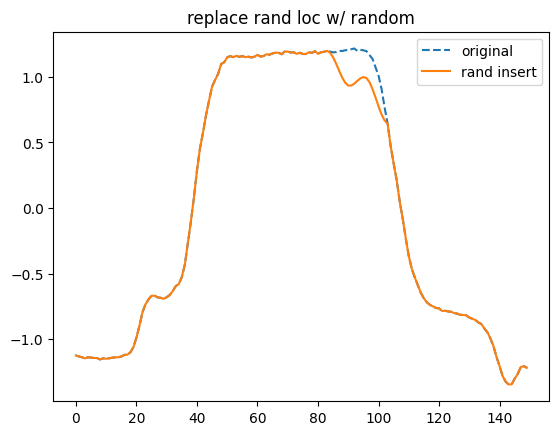

In [33]:
sample_rand = insert_random(sample, len(implet_vals))
plt.plot(sample, ls='--', label='original')
plt.plot(sample_rand, label='rand insert')
plt.title('replace rand loc w/ random')
plt.legend()
plt.show()

In [34]:
def predict(x):
    if len(x.shape) == 1:
        x = x[np.newaxis, np.newaxis, :]
    elif len(x.shape) == 2:
        x = x[np.newaxis]

    if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x).to(device)

    logits = model(x).detach().cpu().numpy()
    return np.argmax(logits, axis=-1)

In [35]:
test_x_overwritten = []
test_x_rand_insert = []

n_trials = 10

for implet in implets:
    i, _, _, _, start_loc, end_loc = implet
    implet_len = end_loc - start_loc + 1
    sample = test_x[i].flatten()
    for _ in range(n_trials):
        sample_overwritten = overwrite_shaplet_random(sample, start_loc, implet_len)
        sample_overwritten = sample_overwritten[np.newaxis]
        test_x_overwritten.append(sample_overwritten)
        
        sample_rand_insert = insert_random(sample, implet_len)
        sample_rand_insert = sample_rand_insert[np.newaxis]
        test_x_rand_insert.append(sample_rand_insert)
        
test_x_overwritten = np.array(test_x_overwritten)
test_x_rand_insert = np.array(test_x_rand_insert)


In [36]:
y_pred_overwritten = predict(test_x_overwritten)
y_pred_rand_insert = predict(test_x_rand_insert)

In [37]:
y_pred = predict(test_x)

In [38]:
print(f'ori: {accuracy_score(test_y, y_pred):.4f}')

# true labels for the modified samples
y_true = np.array([test_y[i] for i, _, _, _, _, _ in implets])
y_true = np.repeat(y_true, n_trials)

print(f'overwritten: {accuracy_score(y_true, y_pred_overwritten):.4f}')
print(f'rand insert: {accuracy_score(y_true, y_pred_rand_insert):.4f}')

ori: 1.0000
overwritten: 0.7428
rand insert: 0.9297
